<a href="https://colab.research.google.com/github/conster303/PFA_ML_Sandbox_CMS/blob/main/Cluster_Sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unsupervised Clustering Sandbox

University of Nevada Reno

Great Basin Center for Geothermal Energy

Author: Connor M. Smith

Date: Aug 4, 2022

Last Update: July 29, 2022 

**Script Purpose** :
Exploring unsupervised clustering applied to the Nevada ML PFA data set and producing outputs of cluster maps and feature variance scores. This script introduces principal component analysis and non-negative matrix factorization and allows the user to isolate training data or incorporate the full feature data set. 

##Set environment and mount Google drive

In [1]:
#To use hdf, pickle, etc., upgrade colab tables
!pip install --upgrade tables -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#Set up directory where data is stored in your google drive

%cd '/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES


\

##Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

from sklearn.decomposition import NMF 
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
from sklearn.metrics import silhouette_samples, silhouette_score



In [4]:
#Import PFA master hdf file preprocessing

import PFA_preprocessing_february2021 as pfa

#Import nmf and pca modules 

import nmf_pca_modules as nmf_pca

##Load data from saved hdf file

In [5]:
df_features = pd.read_hdf('./PFA_dataframe_grid_march2021_df.h5', 'df_features')

#Invert fault recency - now young is high
df_features['FaultRecency'] = df_features['FaultRecency']*-1

extraFeatures = ['GravityDensity', 'MagneticDensity', 
                 'GeochemistryTemperature2',
                 'Silica_Distance', 'TufaOrTravertine_Distance',
                 'DEM-30m', 'FavorableStructuralSettings_Distance']

In [6]:
transformDict = {'features': ['Local-StructuralSetting',
                              'Local-QuaternaryFaultRecency',
                              'Local-QuaternaryFaultSlipDilation', 
                              'Local-QuaternaryFaultSlipRate',
                              'QuaternaryFaultTraces'], 
                 'transforms': ['gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'distance_edt'], 
                 'params': [10, 10, 10, 10, 20]}

# transformDict = {'features': ['QuaternaryFaultTraces'], 
#                  'transforms': ['distance_edt'], 
#                  'params': [20]}

dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_AllNumerical(df_features,
                                                                          transformFeatures=transformDict,
                                                                          extraFeatures=extraFeatures, 
                                                                          prescaleFeatures=True, withMean=True)


In [7]:
#Create a dataframe with all the normalized data

dfInfo['T37'] = df_features['T37']
dfInfo['Domain'] = df_features['Domain']

df_Fairway = pd.concat([dfn,dfInfo],axis=1,sort=False)
df_Fairway.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,...,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,-0.523680,-0.568900,-0.399442,-0.568584,0.521096,-0.506811,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,-0.523768,-0.569068,-0.399476,-0.568743,0.521096,-0.192541,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,-0.523942,-0.569398,-0.399542,-0.569055,0.521096,0.115757,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,-0.524196,-0.569881,-0.399638,-0.569513,0.524190,0.339483,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,-0.524525,-0.570503,-0.399762,-0.570102,0.533434,0.436512,-1.146319,1.738459,-0.630559,-0.640521,...,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


In [8]:
columns = dfn.columns.to_list()

#View all possible feature columns
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [9]:
featureSets = [

# MASTER SET 1
################################
# featureSet = 0
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 1alt: master set 1 with new gravity/magnetic features substituted
################################
# featureSet = 1
################################
['QuaternaryFaultTraces',
 'GravityDensity',
 'MagneticDensity',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2: master set 1 + all local
################################
# featureSet = 2
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 3: master set 1 + geochemistry direct evidence 
################################
# featureSet = 3
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 4: union of master sets 2 and 3
################################
# featureSet = 4
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 2a: master set 1 + local structural setting
################################
# featureSet = 5
################################
['Local-StructuralSetting',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2b: master set 1 + favorable structural settings
################################
# featureSet = 6
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 4b: union of master sets 2b and 3
################################
# featureSet = 7
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 1m: master set 1 minus geodetic strain rate
################################
# featureSet = 8
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
# 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
# MASTER SET 1n: master set 1 minus dem-30m
################################
# featureSet = 9
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
# 'DEM-30m',
],

[
  'GeodeticStrainRate',
 'Earthquakes'
]


]

len(featureSets)

11

In [10]:
feature_set = 2

columns = featureSets[feature_set]


columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

###View Correlation Matrix for feature set

In [11]:
df_Fairway_features = dfn[columns]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


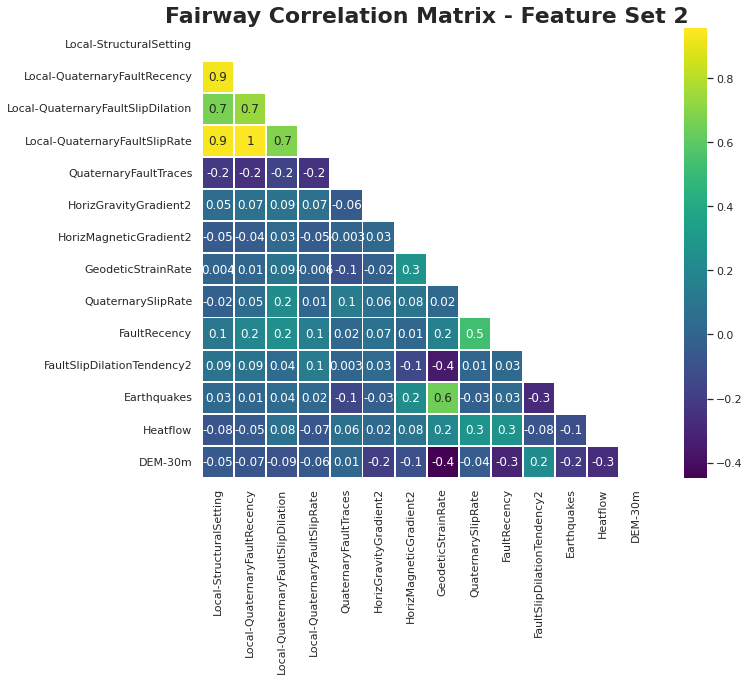

In [12]:
import seaborn as sns


sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
FRWY_correlation_mat = df_Fairway_features.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(FRWY_correlation_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


ax = sns.heatmap(FRWY_correlation_mat, mask = mask, annot = True, linewidths=.95, cmap = 'viridis',annot_kws={"size": 12}, fmt='.1g')

ax.fontweight='bold'
ax.set_aspect("equal")

plt.title('Fairway Correlation Matrix - Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');


###Test plotting

(1728000,)


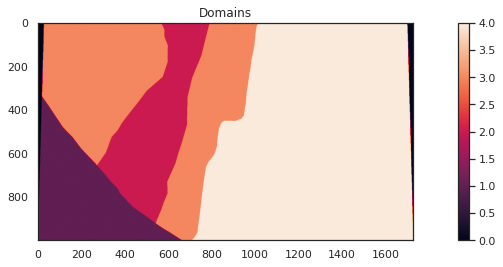

In [13]:
SD = df_Fairway['Domain'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))
#flip it so it is right side up
SD = np.flipud(SD)
#np.fliplr
#SD =np.reshape(SD,(1263,1344))
plt.imshow(SD)
plt.title('Domains')
plt.colorbar()
plt.grid(False)
# 1 wl, 2 cnsb, 3 wgb, 4 carb

## select benchmark sites based on trainCode distance

Select trainCode=1: for 83+ and 62- or trainCode=2: 415+ and 310-


In [14]:
X, y, XyInfo = pfa.makeBenchmarks(dfn, dfInfo, nullIndexes, 
                                          trainCode=1, randomize=True, balance=False)

Number of (+):  83   ; Number of (-):  62


In [15]:
# X, y, XyInfo = pfa.makeBenchmarks(dfC, dfInfoC, nullIndexesC, 
#                                   trainCode=1, randomize=True, balance=True)

In [16]:
print( X.shape, y.shape)

(145, 20) (145,)


In [17]:
X.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
1362053,0.820754,1.554828,0.024491,1.441975,-0.750961,1.478471,-0.929923,0.310926,0.433063,1.327648,-0.579596,0.396714,-0.651118,-1.563044,1.302250,6.627346,-0.371337,-1.198759,-1.382957,-1.835129
1114658,0.159139,-0.035831,-0.185048,0.450917,-1.064303,0.124297,1.007336,0.776121,-0.382452,-1.063107,0.959186,0.142340,0.846476,-0.755529,-1.446561,-0.185826,-0.706206,-0.955277,-0.382220,-1.248053
628693,0.598711,1.561463,-0.188597,1.448535,-1.064303,-1.293578,-0.662004,-0.813587,-1.268894,-0.949120,0.462404,0.118718,-0.697615,0.974860,0.844115,-0.185826,1.697692,1.024066,0.930602,-1.114377
29008,2.059955,3.066342,2.026748,1.457933,-0.559054,4.269271,-0.095253,0.042698,0.925116,-0.450002,-0.557711,0.779572,-1.670693,-1.678404,-0.072156,-0.185826,1.891970,-0.604766,-0.949648,-0.777347
1312446,4.376086,4.072734,4.245795,3.826313,-0.370691,-0.757187,-0.301344,0.978768,-0.274646,1.626223,0.546268,-0.243843,1.401182,0.398064,-0.186690,-0.185826,-0.486835,-0.558497,-0.534394,-0.679006


In [18]:
XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
1362053,788.0,389.0,R789C390,383577.690182,4.455714e+06,notNull,12,1,1,11.0,115.128923,11.0,115.128923,5.0,37786.004366,385,0,12,3
1114658,645.0,98.0,R646C99,310827.690182,4.419964e+06,notNull,12,1,12,4.0,21587.678220,77.0,158.106481,62.0,11342.507776,0,0,1,3
628693,363.0,1429.0,R364C1430,643577.690182,4.349464e+06,notNull,1,12,12,13.0,88489.363691,55.0,37845.040810,41.0,102.621497,37,0,12,4
29008,16.0,1360.0,R17C1361,626327.690182,4.262714e+06,notNull,12,1,1,13.0,90.391257,13.0,90.391257,13.0,5127.079159,266,0,12,4
1312446,759.0,894.0,R760C895,509827.690182,4.448464e+06,notNull,12,1,12,65.0,39038.400381,52.0,66.459185,42.0,50721.821299,294,0,1,3


In [19]:
#Create Dataframe with training site info
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
XyInfo.reset_index(drop=True, inplace=True)


df_Tsite = pd.concat([X,XyInfo],axis=1).reset_index(drop=True)
df_Tsite

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,...,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,0.820754,1.554828,0.024491,1.441975,-0.750961,1.478471,-0.929923,0.310926,0.433063,1.327648,...,11.0,115.128923,11.0,115.128923,5.0,37786.004366,385,0,12,3
1,0.159139,-0.035831,-0.185048,0.450917,-1.064303,0.124297,1.007336,0.776121,-0.382452,-1.063107,...,4.0,21587.678220,77.0,158.106481,62.0,11342.507776,0,0,1,3
2,0.598711,1.561463,-0.188597,1.448535,-1.064303,-1.293578,-0.662004,-0.813587,-1.268894,-0.949120,...,13.0,88489.363691,55.0,37845.040810,41.0,102.621497,37,0,12,4
3,2.059955,3.066342,2.026748,1.457933,-0.559054,4.269271,-0.095253,0.042698,0.925116,-0.450002,...,13.0,90.391257,13.0,90.391257,13.0,5127.079159,266,0,12,4
4,4.376086,4.072734,4.245795,3.826313,-0.370691,-0.757187,-0.301344,0.978768,-0.274646,1.626223,...,65.0,39038.400381,52.0,66.459185,42.0,50721.821299,294,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,3.079862,2.842427,4.732612,2.657676,0.477136,-0.308322,0.574544,1.303287,1.103376,0.474584,...,84.0,156.038716,84.0,156.038716,56.0,26688.265710,177,0,12,1
141,-0.512556,-0.576660,-0.398112,-0.554616,1.598183,-1.248627,-0.528045,-0.713859,-0.861598,-1.411630,...,1.0,46586.158223,15.0,7848.463652,55.0,125.714769,0,0,12,4
142,1.457906,2.562670,0.225990,2.396520,-1.064303,0.061109,-0.940228,0.956187,0.214461,1.178360,...,57.0,39380.529655,51.0,60.981372,42.0,68248.041873,124,0,1,3
143,-0.530227,-0.581814,-0.398818,-0.580812,-0.667953,-0.015821,-0.703223,0.910499,-0.620147,1.565355,...,80.0,22190.635522,80.0,22190.635522,5.0,87.319086,0,0,12,3


In [20]:
##############################
#Tsites
df_Tsite_Features = df_Tsite.copy()[columns]

df_Tsite_Features.rename(columns = {'QuaternaryFaultTraces':'QuaternaryFaultDistance'}, inplace = True)
Tsite_Pos = df_Tsite[df_Tsite['TrainCodePos']!=12]
Tsite_Neg = df_Tsite[df_Tsite['TrainCodePos']==12]
Tsite_PosLOW = Tsite_Pos[Tsite_Pos['TrainCodePosT130']==12] #lower  pos
Tsite_PosBM = Tsite_Pos[Tsite_Pos['TrainCodePosT130']!=12] #Benchmark  pos

##Cluster Time

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

**Goal:** 

Select how many components best represent the data i.e., account for a majority of the variance, and how many clusters to use to visualize the reduced data

##Test variance for number of component selection, and silhouette score for number of cluster selection
 
The variance is mean squared difference between each data point and the centre of the distribution measured by the mean

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [21]:
#Explained variance calcuation
def get_variance(model, data, scorer=metrics.explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data)) #Transform data back to original space
    return scorer(data, prediction)

PCA variance and sillhouette score metrics

In [22]:

from sklearn.decomposition import PCA

n = len(df_Tsite_Features.columns)
#Start at 2 and go up to 8
K = range(2,n)

Variance= []
Reconstruction_err = []
Sill_score = []
for k in K:
    pca = PCA(n_components=k).fit(df_Tsite_Features)
    Variance.append(get_variance(pca,df_Tsite_Features))
    clusterer = KMeans(n_clusters=k)
    pca_score = pca.fit_transform(df_Tsite_Features)
    pred = clusterer.fit_predict(pca_score)
    score = silhouette_score(pca_score, pred)
    Sill_score.append(score)

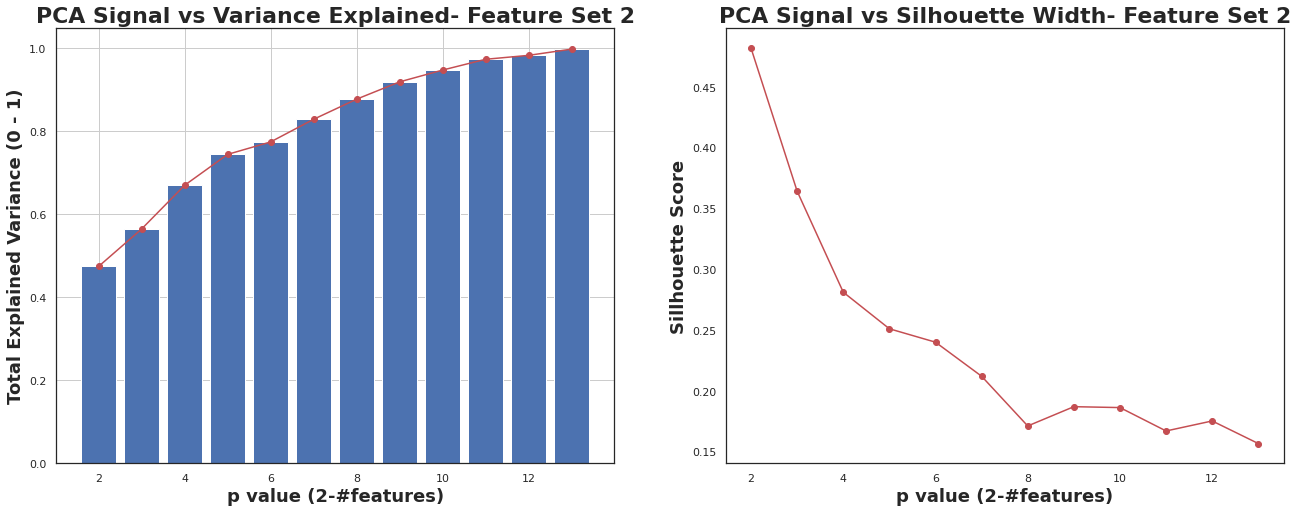

In [23]:
plt.rc('figure', figsize=(22, 8))


plt.subplot(121)

plt.bar(K,Variance)
plt.plot(K, Variance, c='r',marker='o')

plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Total Explained Variance (0 - 1)',fontsize = 18,fontweight='bold')

plt.title('PCA Signal vs Variance Explained- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

#plt.legend(fontsize = 18)
plt.grid(True)


plt.subplot(122)

plt.plot(K,Sill_score,c='r',marker='o')
plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Sillhouette Score',fontsize = 18,fontweight='bold')

plt.title('PCA Signal vs Silhouette Width- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');


NMF variance and sillhouette score metrics 

In [24]:
#Make data non-negative. Add the min value of each variable to all row values.
df_Tsite_Features_abs = df_Tsite_Features.copy()
df_Tsite_Features_abs += np.abs(df_Tsite_Features.copy().min())

#Scale data from 0 to 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_Tsite_FeaturesScaled = scaler.fit_transform(df_Tsite_Features_abs)

In [ ]:
n = len(df_Tsite_Features.columns)

#Start at 2 and go up to 8
K = range(2,n,1)

Variance= []
Reconstruction_err = []
Sill_score = []
for k in K:
    nmf = NMF(n_components=k, init = 'nndsvda').fit(df_Tsite_FeaturesScaled);
     #learn an NMF model for train data and evaluate its performance
    Variance.append(get_variance(nmf,df_Tsite_FeaturesScaled));
    Reconstruction_err.append(nmf.reconstruction_err_);
    clusterer = KMeans(n_clusters=k);
    W = nmf.fit_transform(df_Tsite_FeaturesScaled);
    pred = clusterer.fit_predict(W);
    score = silhouette_score(W, pred);
    Sill_score.append(score);

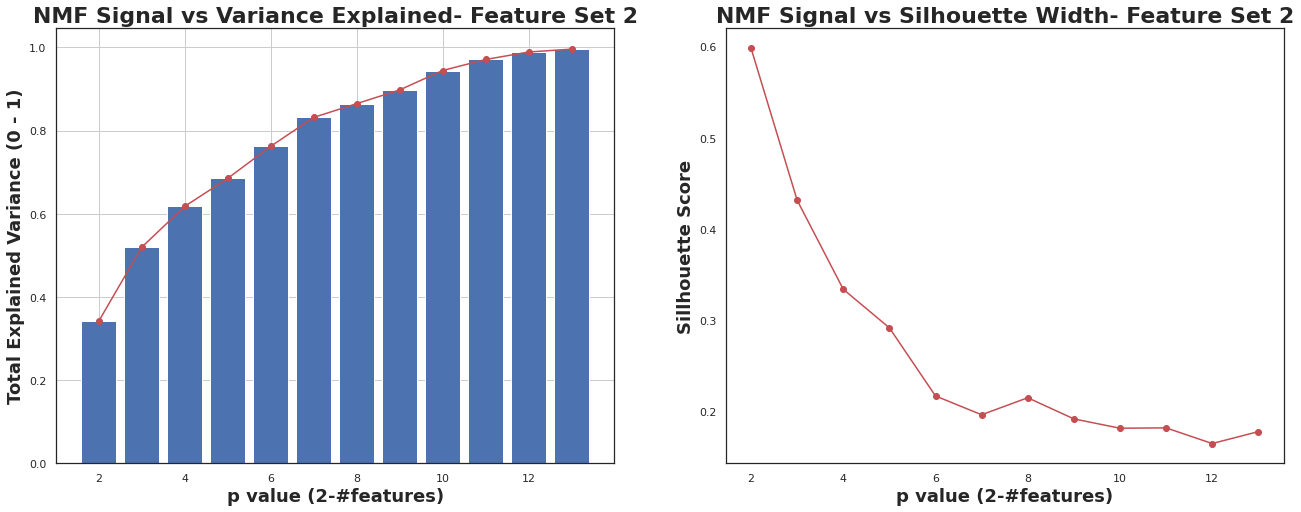

In [26]:
plt.rc('figure', figsize=(22, 8))
#plt.suptitle('Picking Signals (p) for NMF',fontsize = 38,fontweight='bold')


plt.subplot(121)

plt.bar(K,Variance)
plt.plot(K, Variance, c='r',marker='o')

plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Total Explained Variance (0 - 1)',fontsize = 18,fontweight='bold')

plt.title('NMF Signal vs Variance Explained- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

#plt.legend(fontsize = 18)
plt.grid(True)


plt.subplot(122)

plt.plot(K,Sill_score,c='r',marker='o')
plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Sillhouette Score',fontsize = 18,fontweight='bold')

plt.title('NMF Signal vs Silhouette Width- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');


#Select Dimensionality reduction method and parameters to make cluster maps

In [27]:
#components needed to do clustering
components = 4

#Set the number of clusters  
nCluster = 3

##Training Sites

Select NMF of PCA reconstruction

In [28]:
W, H, df_out, centers = nmf_pca.PCA_X(df_Tsite,nCluster,columns,components)

#W, H, df_out, centers = nmf_pca.NMF_X(df_Tsite,nCluster,components,columns)

In [29]:
W.shape

(145, 4)

In [30]:
H.shape

(14, 3)

<function matplotlib.pyplot.tight_layout>

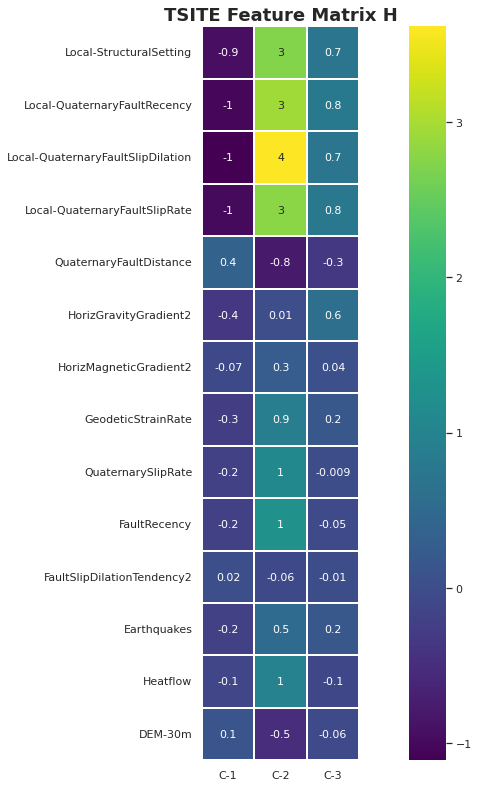

In [31]:
import seaborn as sns

#we can see influence on each of the components by features.
fig= plt.figure(figsize=(18,13.5))

ax = sns.heatmap(H,
                 cmap='viridis', linewidths=.95,
                xticklabels=[ "C-"+str(df_Tsite_Features) for df_Tsite_Features in range(1,nCluster+1)],
                 yticklabels=list(df_Tsite_Features.columns), 
                 annot=True, annot_kws={"size": 11}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")
ax.set_title("TSITE Feature Matrix H",fontsize=18,fontweight='bold')
#ax.invert_yaxis()
plt.tight_layout

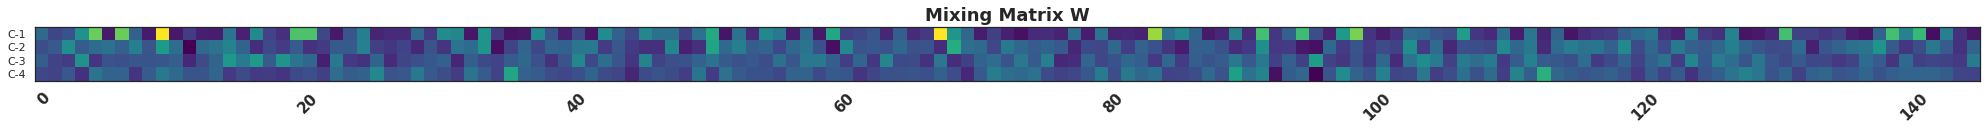

In [32]:
fig, ax = plt.subplots(figsize=(28,28.5))
im = ax.imshow(W[:,range(components)].transpose(), cmap = 'viridis') # cmap='YlGnBu'

# We want to show all ticks...
ax.set_yticks(range(components))
ax.set_yticklabels( "C-"+str(df_Tsite_Features_Group) for df_Tsite_Features_Group in range(1,components+1))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",fontsize=15,fontweight='bold')


ax.set_title("Mixing Matrix W",fontsize=18,fontweight='bold');
fig.tight_layout()

plt.show()

In [33]:
#Groups for positive sites
group1 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
label1 = 'Positive T-Site - Cluster 1: ' + str(len(group1))
group2 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
label2 = 'Positive T-Site - Cluster 2: ' + str(len(group2))
group3 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
label3 = 'Positive T-Site - Cluster 3: ' + str(len(group3))
group4 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 3)]
label4 = 'Positive T-Site - Cluster 4: ' + str(len(group4))

#Groups for negative sites 
group5 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]
label5 = 'Negative T-Site - Cluster 1: ' + str(len(group5))
group6 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]
label6 = 'Negative T-Site - Cluster 2: ' + str(len(group6))
group7 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]
label7 = 'Negative T-Site - Cluster 3: ' + str(len(group7))
group8 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 3)]
label8 = 'Negative T-Site - Cluster 4: ' + str(len(group8))


In [34]:
#Colors for plots
c1 = 'violet'
c2 = 'yellowgreen'
c3 = 'cyan'
c4 = 'red'

<function matplotlib.pyplot.tight_layout>

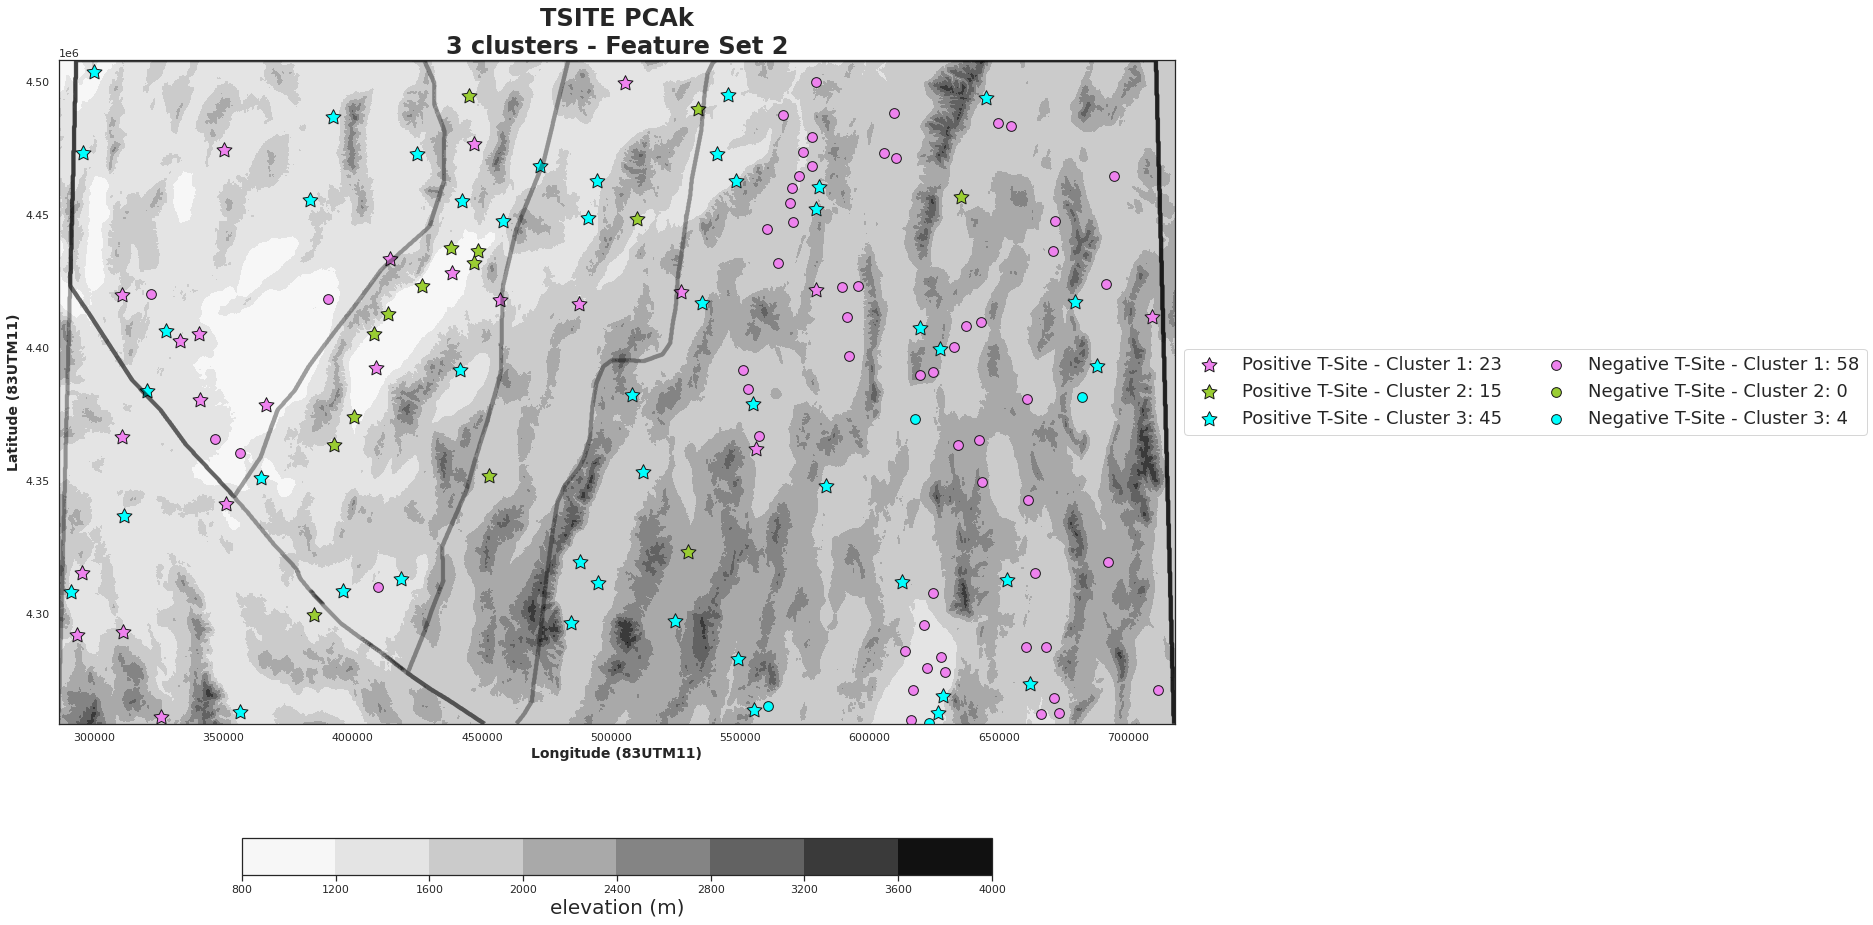

In [35]:
plt.subplots(figsize=(20,15))

#Set up mesh grid plot for Domains and DEM
a = df_Fairway['X_83UTM11']
b = df_Fairway['Y_83UTM11']
Domains = df_Fairway.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values
DEM = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values
X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)

plt.contour(Xa,Ya,Domains,colors='black', linewidths=4, alpha=0.2) 

plt.contourf(Xa,Ya,DEM,cmap = 'Greys')
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal',fraction=0.046, pad=0.14)
#plt.colorbar(im,fraction=0.046, pad=0.04)

#Plot positive sites
plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'],c=c1  ,edgecolors='k', marker=(5, 1),s=245, label=label1)
plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'], c=c2, edgecolors='k',marker=(5, 1),s=245,label=label2)
plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'],   c=c3, edgecolors='k',marker=(5, 1),s=245, label=label3)
#plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c=c4, edgecolors='k',marker=(5, 1),s=245,label=label4)

#Plot negative sites
plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'], c=c1, marker='o',edgecolors='k',s=95,label=label5)
plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'],  c=c2, marker='o',edgecolors='k',s=95,label=label6)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'],   c=c3, marker='o',edgecolors='k',s=95,label=label7)
#plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'],   c=c4, marker='o',edgecolors='k',s=95,label=label8)

ncols = 2
plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', ncol=ncols, bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)

plt.title('TSITE PCAk\n' + str(nCluster) + ' clusters - Feature Set ' + str(feature_set),fontsize=24,fontweight='bold');

plt.tight_layout

#View PCA biplot

In [36]:
n = len(df_Tsite_Features.columns)
pcamodel = PCA(n_components=n)


pcaTsites = pcamodel.fit_transform (df_Tsite_Features)

score = pcaTsites[:,0:2]

score[:,0].shape

xs = score[:,0]
ys = score[:,1]


var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))

In [37]:
#ADD VECTORS
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*10, coeff[i,1]*10,color = 'k',alpha = 0.5, lw = 2 ) #MULTIPLY BY 10
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 10.00, coeff[i,1] * 10.00, labels[i],color = 'k',horizontalalignment='center', verticalalignment='center_baseline', rotation=angle, rotation_mode='anchor', fontsize=12,fontweight='bold')
 
    plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
    plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)

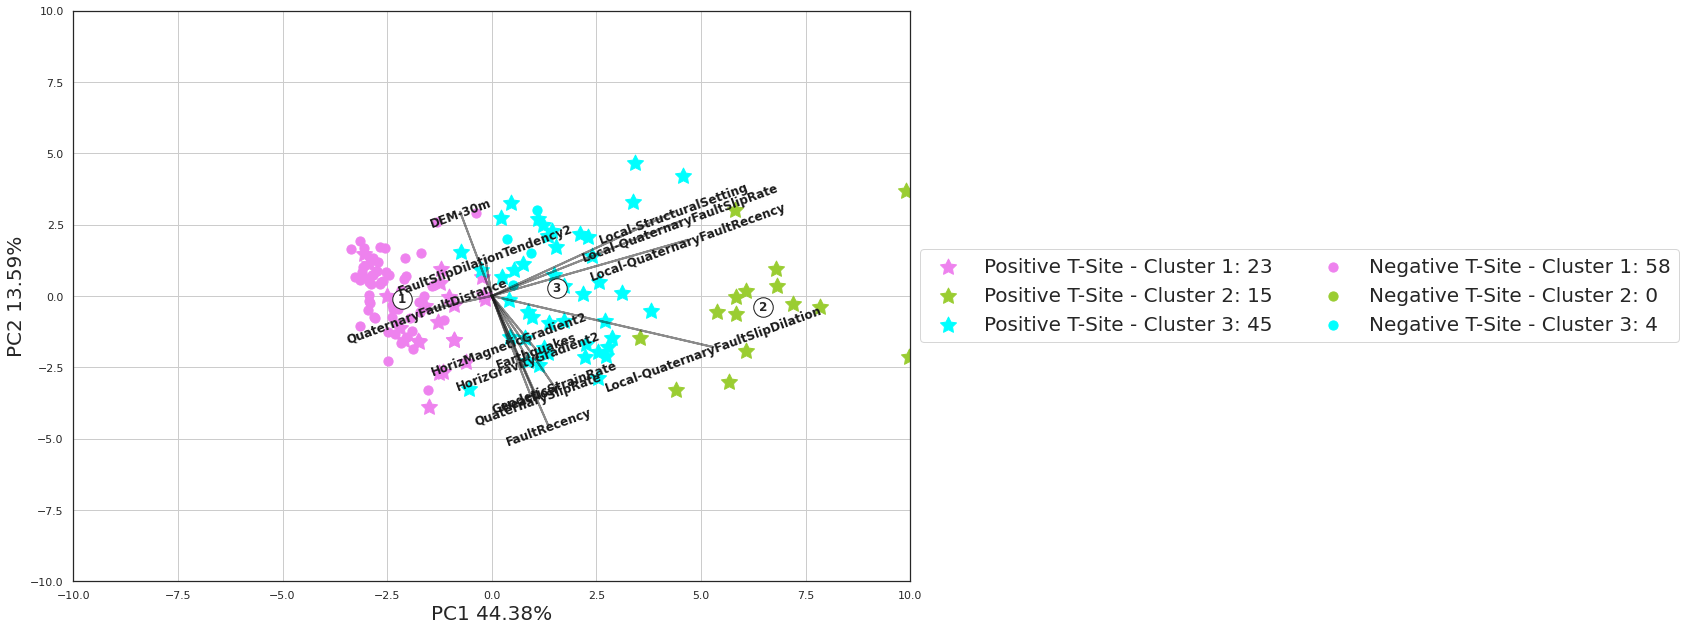

In [41]:
fig= plt.figure(figsize=(15,10.5)) 
#plot kmeans data
from scipy.spatial.distance import cdist

plt.scatter(group1['PC1'], group1['PC2'],c=c1,s=285,marker=(5, 1), label=label1)
plt.scatter(group2['PC1'], group2['PC2'], c=c2,s=285, marker=(5, 1),label=label2)            
plt.scatter(group3['PC1'], group3['PC2'],  c=c3,s=285, marker=(5, 1),label=label3)
#plt.scatter(group4['PC1'], group4['PC2'],  c=c4,s=285, marker=(5, 1),label=label4)
            
plt.scatter(group5['PC1'], group5['PC2'], c=c1,s=85, marker='o', label=label5)   
plt.scatter(group6['PC1'], group6['PC2'], c=c2,s=85, marker='o',label=label6)
plt.scatter(group7['PC1'], group7['PC2'],  c=c3,s=85, marker='o',label=label7)            
#plt.scatter(group8['PC1'], group8['PC2'],  c=c4,s=85, marker='o',label=label8)            

angle = 20

#Plot Kmeans center locations
plt.scatter(centers[:,0] , centers[:,1] , s = 380, marker='o', edgecolors='k',color = 'white')
for i in range(centers.shape[0]):
    plt.text(centers[i,0], centers[i,1], str(i+1),fontsize=12,fontweight='bold',horizontalalignment='center', verticalalignment='center')


plt.xlim([-10, 10])
plt.ylim([-10, 10]) 

plt.grid()

myplot(pcaTsites[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(df_Tsite_Features.columns))
ncols = 2
plt.legend(scatterpoints=1, ncol=ncols, loc='center left',bbox_to_anchor=(1, 0.5),fontsize=20)

##Fairway

Select NMF of PCA reconstruction

In [42]:
W, H, df_out, centers = nmf_pca.PCA_X(df_Fairway,nCluster,columns,components)


#W, H, df_out, centers = nmf_pca.NMF_X(df_Fairway,nCluster,components,columns)

<function matplotlib.pyplot.tight_layout>

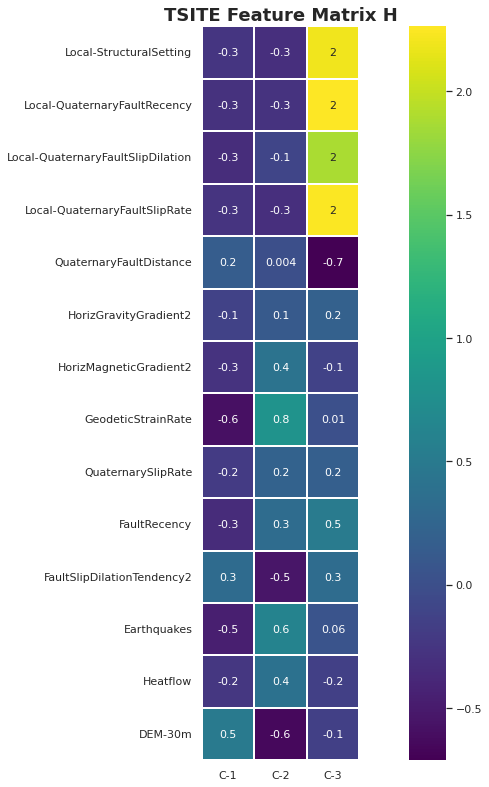

In [43]:
import seaborn as sns

#we can see influence on each of the components by features.
fig= plt.figure(figsize=(18,13.5))

ax = sns.heatmap(H,
                 cmap='viridis', linewidths=.95,
                xticklabels=[ "C-"+str(df_Tsite_Features) for df_Tsite_Features in range(1,nCluster+1)],
                 yticklabels=list(df_Tsite_Features.columns), 
                 annot=True, annot_kws={"size": 11}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")
ax.set_title("TSITE Feature Matrix H",fontsize=18,fontweight='bold')
#ax.invert_yaxis()
plt.tight_layout

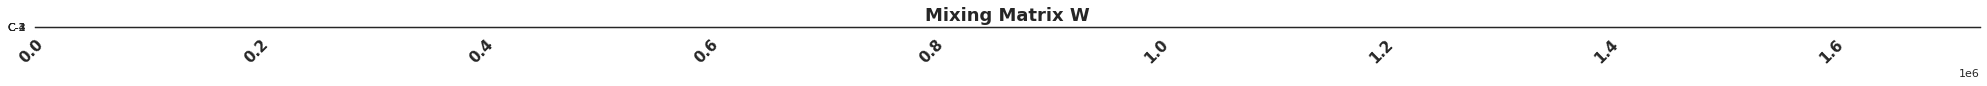

In [44]:
fig, ax = plt.subplots(figsize=(28,28.5))
im = ax.imshow(W.transpose(), cmap = 'viridis') # cmap='YlGnBu'

# We want to show all ticks...
ax.set_yticks(range(components))
ax.set_yticklabels( "C-"+str(df_Tsite_Features_Group) for df_Tsite_Features_Group in range(1,components+1))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",fontsize=15,fontweight='bold')


ax.set_title("Mixing Matrix W",fontsize=18,fontweight='bold');
fig.tight_layout()

plt.show()

In [45]:
#Groups for the fairway
group1 = df_out[df_out['KMeansGrp']==0]
label1 = 'Cluster 1'
group2 = df_out[df_out['KMeansGrp']==1]
label2 = 'Cluster 2'
group3 = df_out[df_out['KMeansGrp']==2]
label3 = 'Cluster 3'
group4 = df_out[df_out['KMeansGrp']==3]
label4 = 'Cluster 4'

#Groups for positive sites
group5 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
label5 = 'Positive T-Site - Cluster 1: ' + str(len(group5))

group6 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
label6 = 'Positive T-Site - Cluster 2: ' + str(len(group6))

group7 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
label7 = 'Positive T-Site - Cluster 3: ' + str(len(group7))

group8 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 3)]
label8 = 'Positive T-Site - Cluster 4: ' + str(len(group8))

#Groups for negative sites 
group9 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]
label9 = 'Negative T-Site - Cluster 1: ' + str(len(group9))

group10 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]
label10 = 'Negative T-Site - Cluster 2: ' + str(len(group10))

group11 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]
label11 = 'Negative T-Site - Cluster 3: ' + str(len(group11))

group12 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 3)]
label12 = 'Negative T-Site - Cluster 4: ' + str(len(group12))

In [46]:
#Colors for plots
c1 = 'violet'
c2 = 'yellowgreen'
c3 = 'cyan'
c4 = 'red'

<function matplotlib.pyplot.tight_layout>

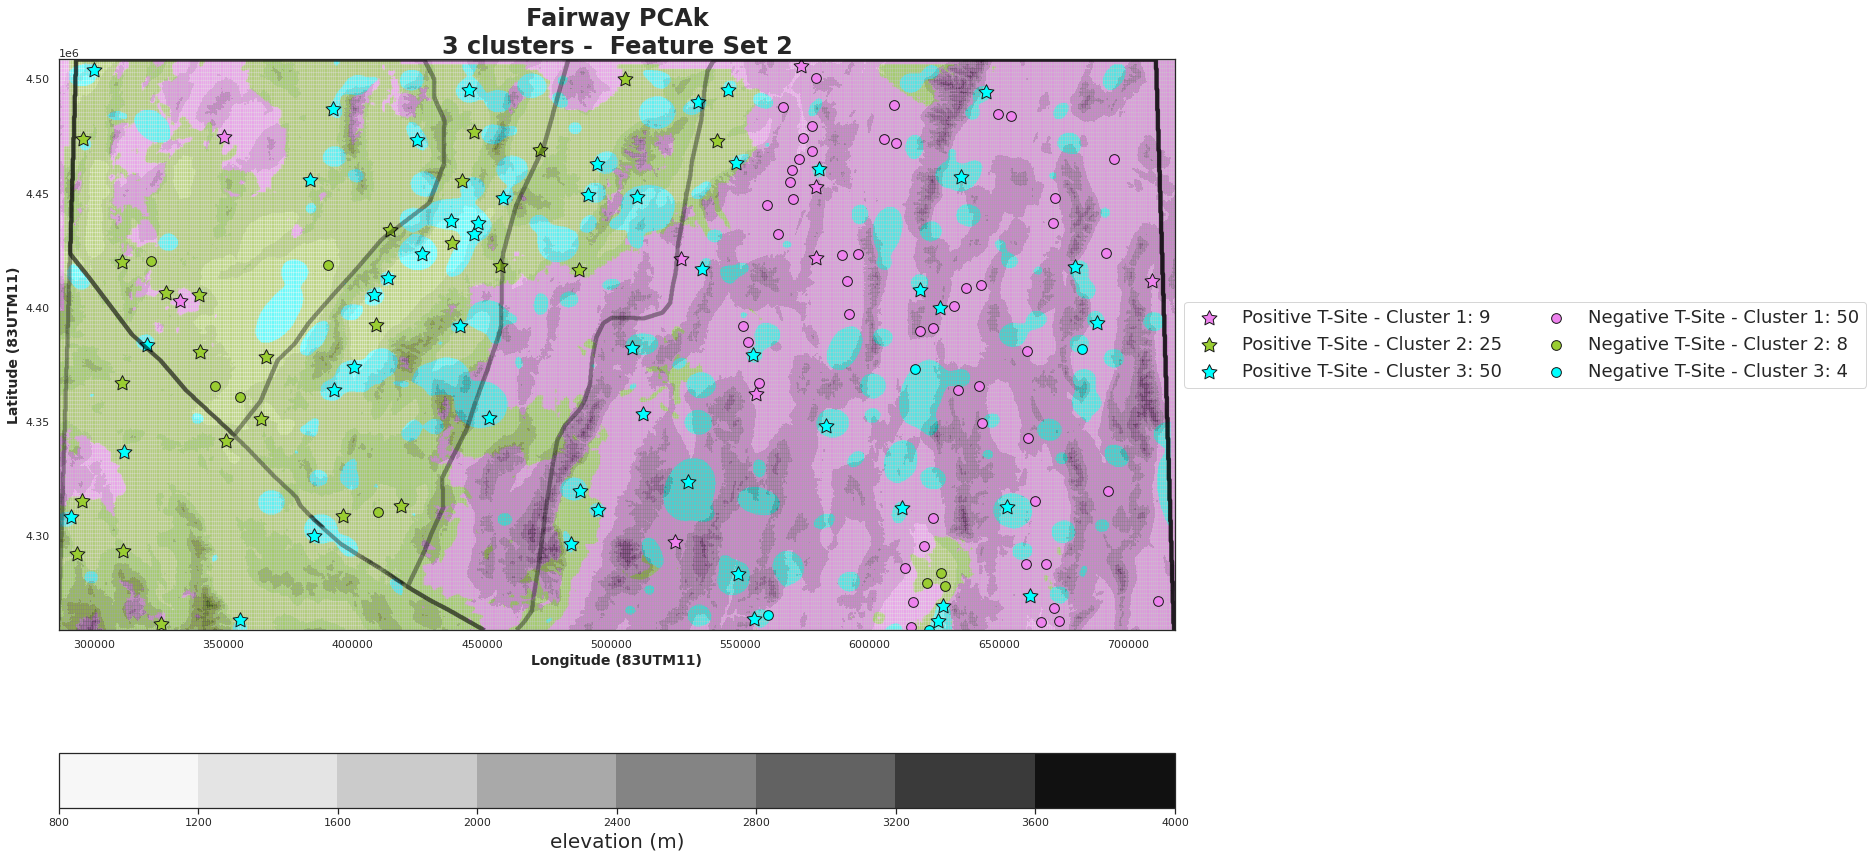

In [47]:
plt.subplots(figsize=(20,15))

#Set up mesh grid plot for Domains and DEM
a = df_Fairway['X_83UTM11']
b = df_Fairway['Y_83UTM11']
Domains = df_Fairway.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values
DEM = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values
X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)

plt.contour(Xa,Ya,Domains,colors='black', linewidths=4, alpha=0.2) 

plt.contourf(Xa,Ya,DEM,cmap = 'Greys')
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')

#Plot all points
plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'],c=c1 ,marker='.',s=0.05,alpha = 0.5)
plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'],c=c2, marker='.',s=0.05, alpha = 0.5)
plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'], c=c3, marker='.',s=0.05, alpha = 0.5)
plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c=c4, marker='.',s=0.05,alpha = 0.5)

#Plot positive sites
plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'],  c=c1,edgecolors='k', marker=(5, 1),s=245, label=label5)
plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'], c=c2, edgecolors='k',marker=(5, 1),s=245,label=label6)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'],  c=c3 , edgecolors='k',marker=(5, 1),s=245, label=label7)
#plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'],  c=c4, edgecolors='k',marker=(5, 1),s=245,label=label8)

#Plot negative sites
plt.scatter(group9['X_83UTM11'], group9['Y_83UTM11'], c=c1 , marker='o',edgecolors='k',s=95,label=label9)
plt.scatter(group10['X_83UTM11'], group10['Y_83UTM11'], c=c2, marker='o',edgecolors='k',s=95,label=label10)
plt.scatter(group11['X_83UTM11'], group11['Y_83UTM11'], c=c3, marker='o',edgecolors='k',s=95,label=label11)
#plt.scatter(group12['X_83UTM11'], group12['Y_83UTM11'],  c=c4, marker='o',edgecolors='k',s=95,label=label12)

ncols = 2
plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', ncol=ncols, bbox_to_anchor=(1, 0.5),fontsize = 18)

#plt.grid(True)

plt.title('Fairway PCAk\n' + str(nCluster) + ' clusters -  Feature Set ' + str(feature_set),fontsize=24,fontweight='bold');

plt.tight_layout

##View PCA Biplot

In [48]:
n = len(df_Fairway_features.columns)
pcamodel = PCA(n_components=n)
pcaFRWY = pcamodel.fit_transform (df_Fairway_features)

score= pcaFRWY[:,0:2]

#Index the scores from the PCA reconstruction
xs = score[:,0]
ys = score[:,1]

var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))

In [49]:
#ADD VECTORS
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*10, coeff[i,1]*10,color = 'k',alpha = 0.5, lw = 2 ) #MULTIPLY BY 10
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 10.00, coeff[i,1] * 10.00, labels[i],color = 'k',horizontalalignment='center', verticalalignment='center_baseline', fontsize=15,fontweight='bold')


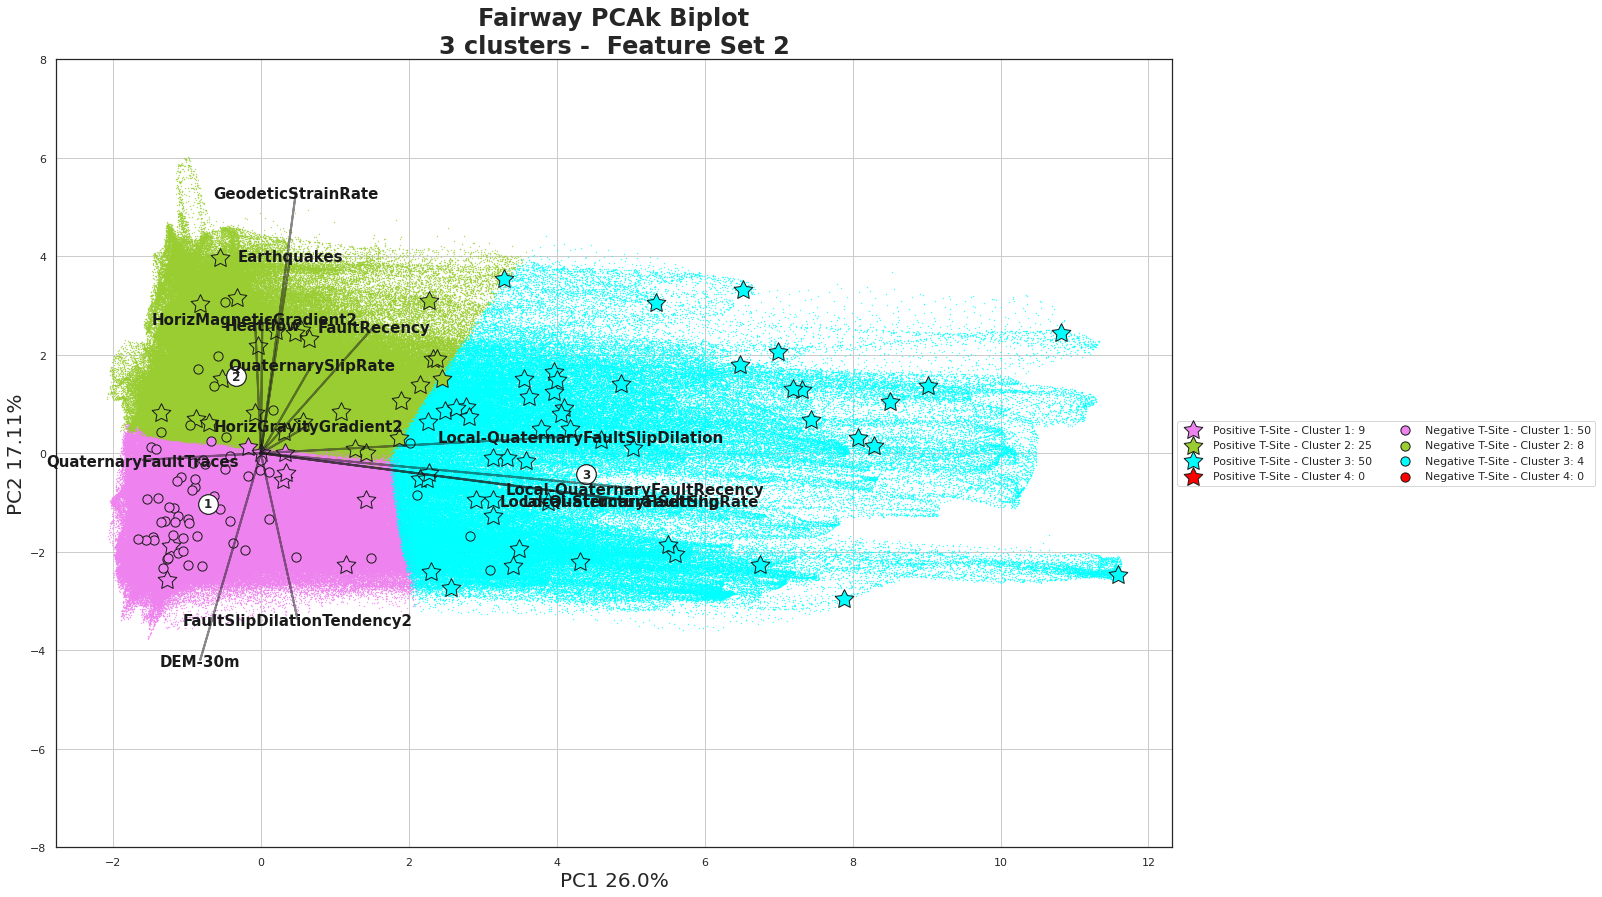

In [50]:
#Plot biplot with k means groups

plt.subplots(figsize=(20,14.5))

plt.scatter(group1['PC1'], group1['PC2'], c=c1,s=0.5,marker='.')
plt.scatter(group2['PC1'], group2['PC2'],c=c2, s=0.5,marker='.')
plt.scatter(group3['PC1'], group3['PC2'], c=c3,s=0.5,marker='.')
plt.scatter(group4['PC1'], group4['PC2'], c=c4,s=0.5,marker='.')


plt.scatter(group5['PC1'], group5['PC2'], c=c1,edgecolors='k',s=385, marker=(5, 1),label=label5)
plt.scatter(group6['PC1'], group6['PC2'],c=c2, edgecolors='k',s=385, marker=(5, 1), label=label6) 
plt.scatter(group7['PC1'], group7['PC2'],c=c3,edgecolors='k',s=385, marker=(5, 1),label=label7)
plt.scatter(group8['PC1'], group8['PC2'], c=c4,edgecolors='k',s=385, marker=(5, 1),label=label8)



plt.scatter(group9['PC1'], group9['PC2'], c=c1,edgecolors='k',s=85,marker='o', label=label9)
plt.scatter(group10['PC1'], group10['PC2'],c=c2,edgecolors='k',s=85,marker='o', label=label10)
plt.scatter(group11['PC1'], group11['PC2'],c=c3 , edgecolors='k',s=85,marker='o', label=label11) 
plt.scatter(group12['PC1'], group12['PC2'], c=c4,edgecolors='k',s=85,marker='o', label=label12)


#Plot Kmeans center locations
plt.scatter(centers[:,0] , centers[:,1] , s = 380, marker='o', edgecolors='k',color = 'white')
for i in range(centers.shape[0]):
    plt.text(centers[i,0], centers[i,1], str(i+1),fontsize=12,fontweight='bold',horizontalalignment='center', verticalalignment='center')


#plt.xlim([-5, 7])
plt.ylim([-8, 8]) 

myplot(pcaFRWY[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(df_Fairway_features.columns))

#Plot Kmeans center locations
plt.scatter(centers[:,0] , centers[:,1] , s = 380, marker='o', edgecolors='k',color = 'white')


plt.title('Fairway PCAk Biplot\n' + str(nCluster) + ' clusters -  Feature Set '+ str(feature_set),fontsize=24,fontweight='bold');

ncols = 2
plt.legend(loc='center left',ncol=ncols, bbox_to_anchor=(1, 0.5))

plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)

ax.set_facecolor('white')
plt.grid(True)
